# Plot statistics

Compute and plot statistics about our data

In [1]:
import typing
import os
import os.path as op
import pandas as pd
import mplhep
from matplotlib import rcParams
import matplotlib.pyplot as plt
from uncertainties import ufloat, UFloat
import numpy as np


# Style for the plot
mplhep.style.use(mplhep.style.LHCb2)
rcParams.update({"font.serif": "DejaVu Serif"})

In [2]:
def get_mean(distribution: np.ndarray) -> UFloat:
    """Get mean of a distribution (with standard deviation)"""
    return ufloat(distribution.mean(), distribution.std())

## Configuration

In [3]:
indir = "/home/acorreia/Documents/PhD/tracking/data/csv/v2/minbias-sim10b-xdigi/0"

filenames = [
    "hits_velo",
    "mc_particles"
]

ext = ".parquet.lz4"

detectors = ["velo", "ut", "scifi"]

outdir = "output"
os.makedirs(outdir, exist_ok=True)

## Load files

In [4]:
def read_parquet(filename: str, **kwargs) -> pd.DataFrame:
    inpath = op.join(indir, filename + ext)
    print("Reading", inpath)
    return pd.read_parquet(inpath, **kwargs)

In [5]:
dataframes = {}

for datatype in ["mc_particles"] + [f"hits_{detector}" for detector in detectors]:
    dataframes[datatype] = read_parquet(datatype)

Reading /home/acorreia/Documents/PhD/tracking/data/csv/v2/minbias-sim10b-xdigi/0/mc_particles.parquet.lz4
Reading /home/acorreia/Documents/PhD/tracking/data/csv/v2/minbias-sim10b-xdigi/0/hits_velo.parquet.lz4
Reading /home/acorreia/Documents/PhD/tracking/data/csv/v2/minbias-sim10b-xdigi/0/hits_ut.parquet.lz4
Reading /home/acorreia/Documents/PhD/tracking/data/csv/v2/minbias-sim10b-xdigi/0/hits_scifi.parquet.lz4


## Number of hits

In [6]:
def count_hits(hits: pd.DataFrame) -> pd.Series:
    return hits.drop_duplicates(["event", "lhcbid"]).groupby("event").size()

### Number of hits / MC particles

In [7]:
nhits_per_mc_particles = {}
for detector in detectors:
    nhits_per_mc_particles[detector] = (
        dataframes[f"hits_{detector}"].groupby(["event", "mcid"]).size()
    )


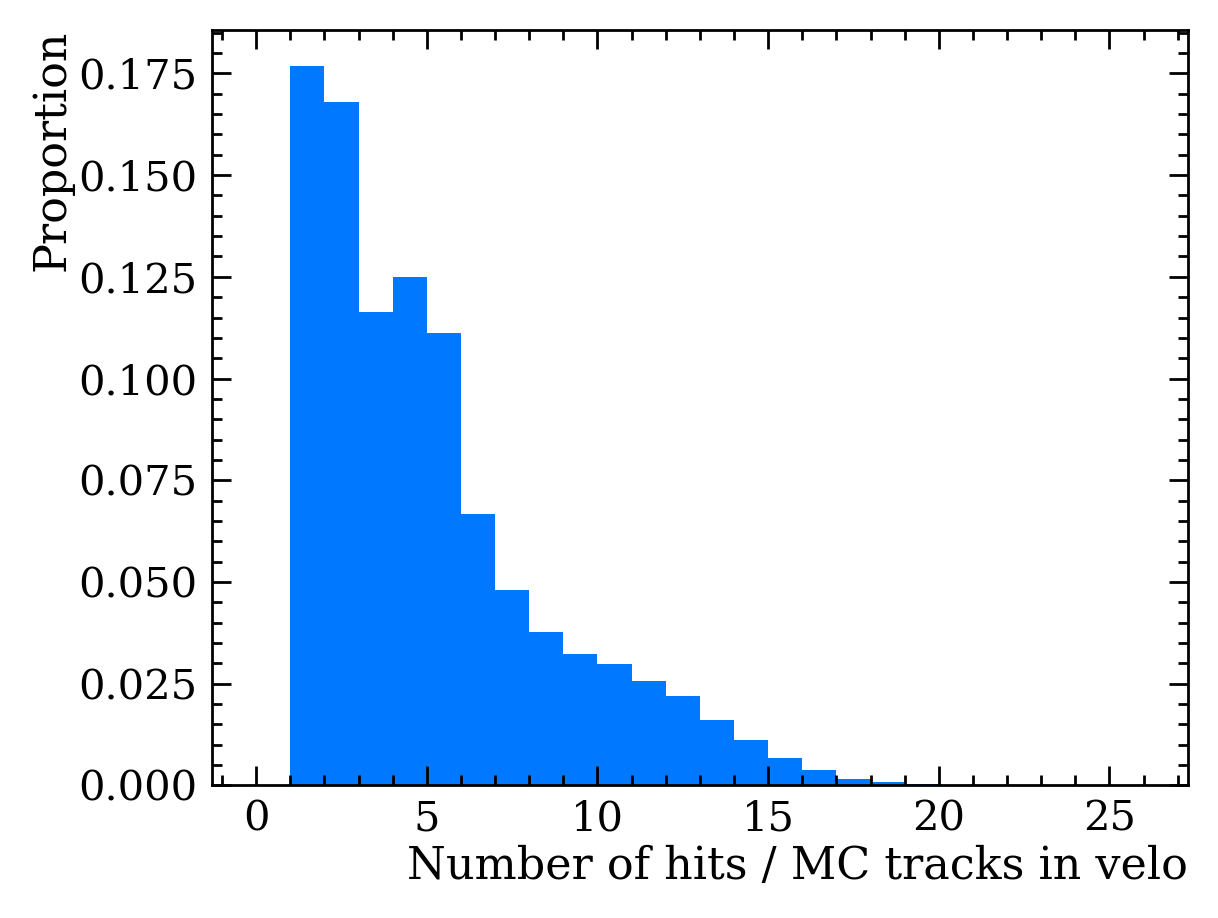

In [8]:
fig, ax = plt.subplots()
ax.hist(nhits_per_mc_particles["velo"], range=(0, 26), density=True, bins=26)
ax.set_xlabel("Number of hits / MC tracks in velo")
ax.set_ylabel("Proportion")
fig.savefig(op.join(outdir, "nhits_per_track.pdf"))

### Number of true and fake hits / event

Proportion of fake hits: 13.43688227122233 %


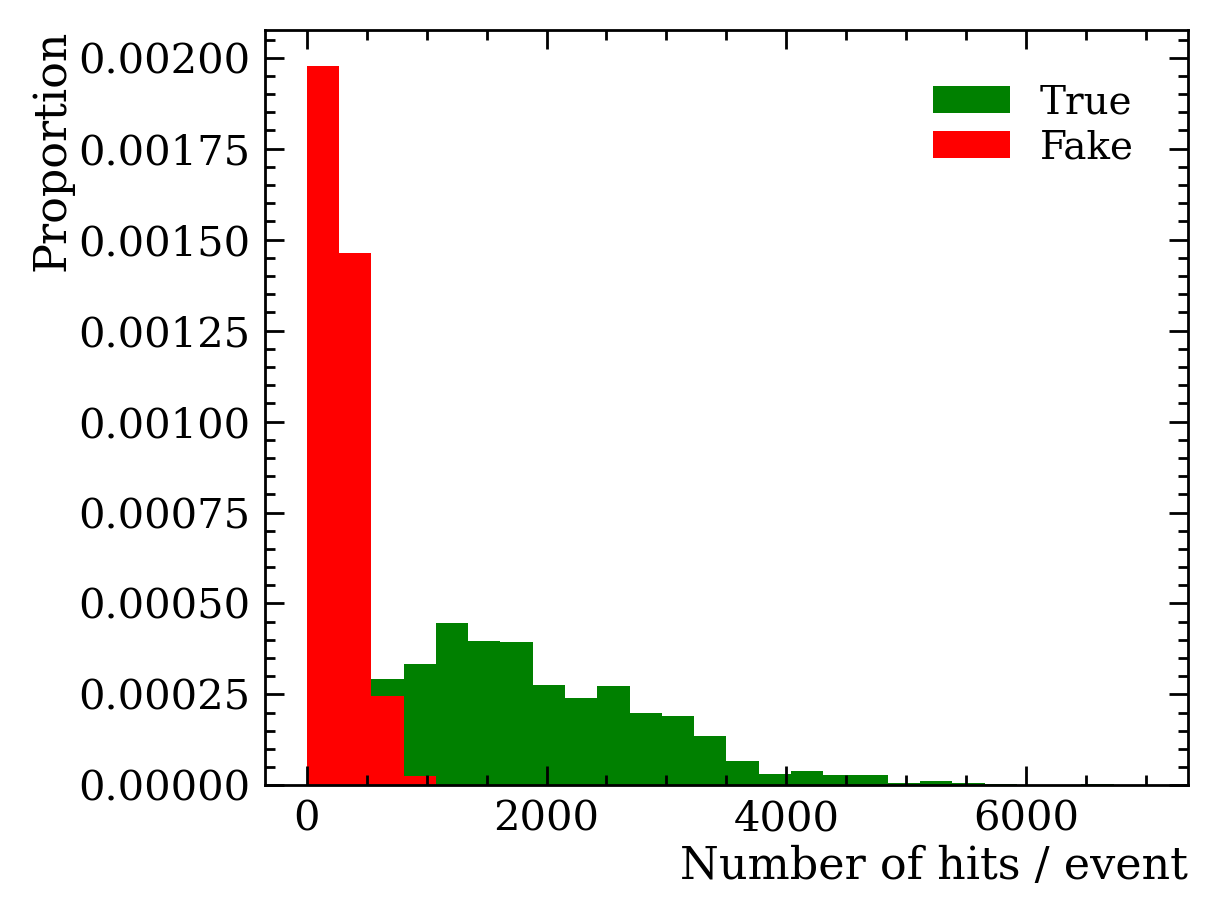

In [9]:
fig, ax = plt.subplots()

hist_kwargs = dict(
    density=True,
    bins=26,
    range=(0, 7000)
)

hits_per_event_true = count_hits(dataframes["hits_velo"].query("mcid != -1"))
hits_per_event_fake = count_hits(dataframes["hits_velo"].query("mcid == -1"))

nhits_true = hits_per_event_true.sum()
nhits_fake = hits_per_event_fake.sum()
prop_hits_fake = nhits_fake / (nhits_fake + nhits_true)
print("Proportion of fake hits:", prop_hits_fake * 100, '%')

ax.hist(hits_per_event_true, label='True', color='g', **hist_kwargs)
ax.hist(hits_per_event_fake, label="Fake", color='r', **hist_kwargs)
ax.set_xlabel("Number of hits / event")
ax.set_ylabel("Proportion")
ax.legend()

fig.savefig(op.join(outdir, "nhits_per_event"))

## Number of tracks

In [10]:
# def get_nb_reconstructible_tracks_per_event(
#     hits_velo: pd.DataFrame,
# ) -> np.ndarray:
#     hits_velo_per_mcid_event = hits_velo.groupby(["event", "mcid"])
#     #: Number of reconstructible tracks / event
#     ntracks_reconstructible_per_event = (
#         (hits_velo_per_mcid_event["lhcbid"].count() >= 3).groupby("event").sum()
#     )
#     return ntracks_reconstructible_per_event

In [11]:
cuts = {
    "all": None,
    "reco": "has_velo == True",
    "acc": "2 < eta < 5",
}
cuts["reco_acc"] = f"({cuts['reco']}) and ({cuts['acc']})"

colors = {
    "all": 'b',
    "reco": 'darkorange',
    "acc": "purple",
    "reco_acc": 'g'
}

labels = {
    "all": "All",
    "reco": "Reco.",
    "acc": "In acc.",
    "reco_acc": "Reco. and in acc.",
}

In [12]:
hits_velo_true = dataframes["hits_velo"].query("mcid != -1")
hits_velo_true = hits_velo_true.merge(
    dataframes["mc_particles"][["event", "mcid", "eta", "has_velo"]],
    on=["event", "mcid"],
    how="left"
)



In [13]:
dict_hits_velo_true = {}
for cat, cut in cuts.items():
    if cut is None:
        dict_hits_velo_true[cat] = hits_velo_true
    else:
        dict_hits_velo_true[cat] = hits_velo_true.query(cut)

In [14]:
dict_ntracks_per_event = {}
for cat, hits_velo_true_cat in dict_hits_velo_true.items():
    dict_ntracks_per_event[cat] = hits_velo_true_cat.groupby(["event"])[
        "mcid"
    ].nunique()


In [15]:
print("| Category | Number of events / track |")
print("| -- | -- |")
for cat, ntracks_per_event in dict_ntracks_per_event.items():
    print('|', f"{labels[cat]:>15}", '|', f"{get_mean(ntracks_per_event):.1f}", '|')


| Category | Number of events / track |
| -- | -- |
|             All | 398.5+/-225.9 |
|           Reco. | 251.5+/-142.9 |
|         In acc. | 132.5+/-77.8 |
| Reco. and in acc. | 121.0+/-71.0 |


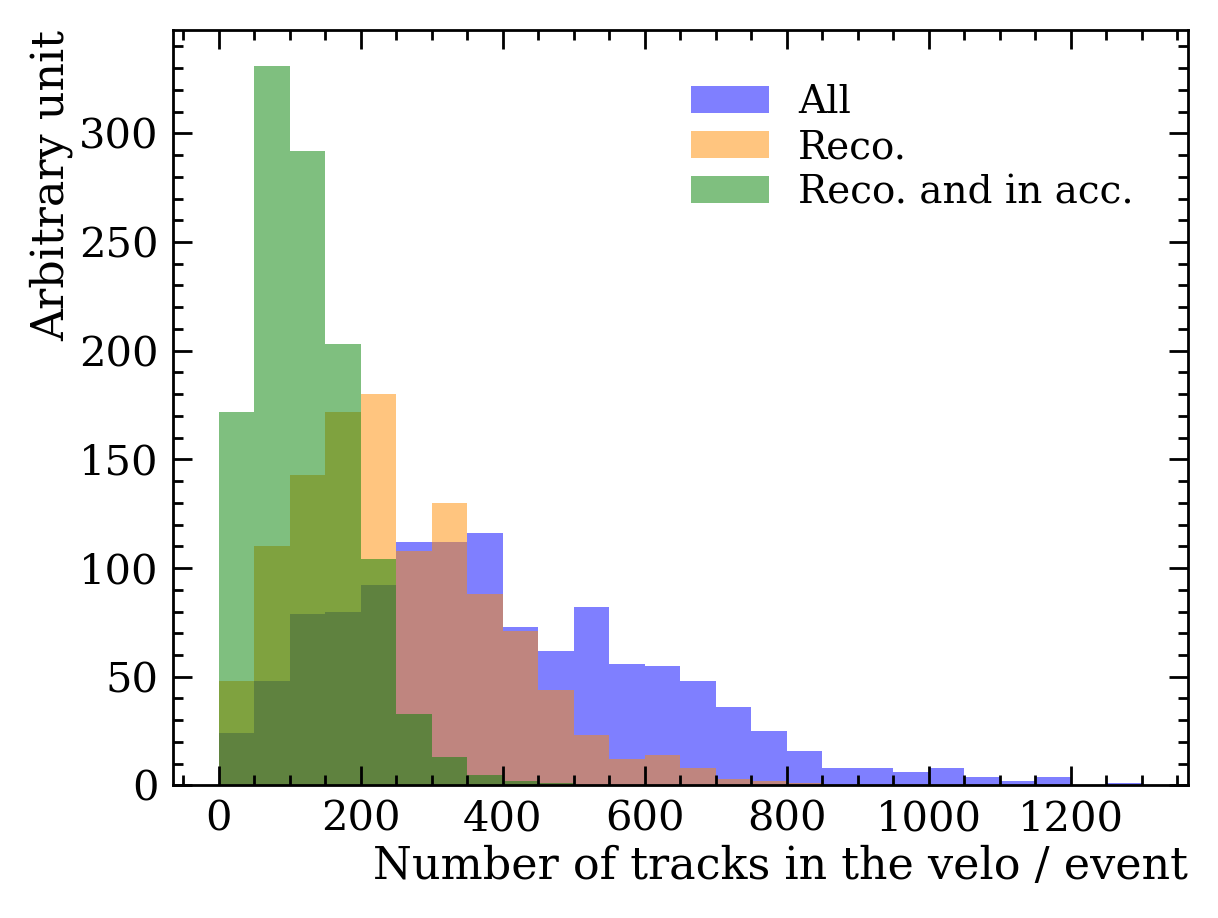

In [16]:
fig, ax = plt.subplots()

hist_kwargs = dict(density=False, bins=26, range=(0, 1300), alpha=0.5)

cats = ["all", "reco", "reco_acc"]
for cat in cats:
    ax.hist(
        dict_ntracks_per_event[cat], label=labels[cat], color=colors[cat], **hist_kwargs
    )

ax.set_xlabel("Number of tracks in the velo / event")
ax.set_ylabel("Arbitrary unit")
ax.legend()

fig.savefig(op.join(outdir, "ntracks_per_event.pdf"))
